# Initialisation du projet

In [ ]:
import getpass
import os

# API KEYS
def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("MISTRAL_API_KEY")
_set_env("TAVILY_API_KEY")


In [2]:
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

# Charger le vectorstore Chroma existant
embeddings = HuggingFaceEmbeddings(
    model_name="jinaai/jina-embeddings-v3",
    model_kwargs={"trust_remote_code": True}
)
vectorstore = Chroma(
    embedding_function=embeddings,
    persist_directory="./chroma_db"
)

/Users/geoffreypruvost/Projets/cours_agents_IA/students/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


# Objectif du notebook

Nous allons créer un RAG agentique sous forme de workflow. 

Outils à disposition de l'agent : 
- chercher dans ChromaDB

Le workflow : 
1. Un LLM est chargé de générer une réponse directementà la question ou de générer l'appel à un des outils pour obtenir des informations complémentaires.
2. Si le LLM décide d'appeler un outil alors on doit l'utiliser.
3. Une fois le résultat de l'outil récupéré, on demande à un LLM d'évaluer si les données complémentaires sont pertinentes pour répondre à la question.
4. Si les données complémentaires sont pertinentes, alors on génère une réponse finale avec ses données. (RAG classique)
5. Sinon on repart à l'étape 1 pour recommencer en reformulant la question.

# Les Outils / tools

In [ ]:

# Création de l'outil "retriever" pour chercher dans ChromaDB



tools = [retriever_tool]

In [4]:
# test de l'outil
retriever_tool.invoke({"query": "brevet"})

"id: 3\nname: Geoffrey Pruvost\njob: Directeur Technique\ncofounder: False\n\nQuand a-t-on besoin de connaître la valeur d’une marque ou d’un brevet\xa0?\n  \nPendant les phases de fusion, d'acquisition ou de vente d'une entreprise ;Dans des phases de réorganisation entre tête de groupe et filiales et de changement d’intégration fiscalePour la gestion des actifs immatériels et l'amortissement comptable ;En situation de litige ;Pour négocier des contrats ;Fiscalité (IP BOX).En savoir plusComment ?\n  Les indicateurs financiers clés pour mesurer la valeur d’un actif de PI au sein de l'entreprise\xa0: \n  \n\nDépenses de recherche, développement ou d’acquisition\xa0;\nRevenus directs liés à l’exploitation\xa0;\nRevenus indirects\xa0;\nCA réel et prévisionnel\xa0;\n\nEn savoir plusEtape 1Récolte de données J+0Etape 2AnalyseEtape 3Rapport détailléJ+15 Cas d'usageStartup biotechContexte : Valorisation d’un portefeuille de brevets en vue de la liquidation d’une filialeProblématique : Comment 

# Les noeuds du graphe


### Création du noeud d'entrée

Le premier noeud conciste à appeler un LLM avec la question de l'utilisateur.
On lui donne accès aux outils disponibles et il choisira s'il veut les utiliser.

Dans le cas où il estime qu'il en a besoin, il générera une demande d'appelle à l'outils sans l'exécuter (un noeud dédié à l'outil est nécessaire pour l'exécuter).

In [ ]:
from langchain.chat_models import init_chat_model
from langgraph.graph import MessagesState


model = init_chat_model("mistral-large-latest", temperature=0)


def generate_answer_or_call_tools(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """


In [39]:
# Test du noeud generate_query_or_respond
input = {"messages": [{"role": "user", "content": "Est-ce que Diag n'grow évalue des brevets ?"}]}
messages = generate_answer_or_call_tools(input)["messages"]
for message in messages:
    print(message.pretty_print())

================================== Ai Message ==================================
Tool Calls:
  retrieve_in_vector_database (3ivKyuZpv)
 Call ID: 3ivKyuZpv
  Args:
    query: Diag n'Grow évaluation des brevets
None


### Le noeud "Call a tool"

Les outils ont besoin d'un noeud pour être exécutés. 
On va donc créer un noeud "call_tool_node" : 
- on va récupérer la requete venant du noeud précédent
- on va appeler l'outil correspondant
- on va retourner le résultat de l'outil

In [ ]:



# Noeud call_tool_node qui utilise l'outil demandé par le LLM


### Noeud de notation de la réponse

In [ ]:
from pydantic import BaseModel, Field
from typing import Literal



def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""

   


In [ ]:
from langchain.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Tools already called: {tools_called}\n"
    "Formulate an improved question without detail your choice. Answer only with the new question.\n"
    "The rewritten question must include an explicit instruction to call a tool and, if possible, a different one than previously used."
)

response_model = init_chat_model("mistral-large-latest", temperature=0)

def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    

In [ ]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    

# Assemblage du graphe

In [ ]:
from langgraph.graph import StateGraph


workflow = StateGraph(MessagesState)

# Ajout des noeuds



# Ajout des arrêtes 


# Compile
graph = workflow.compile()

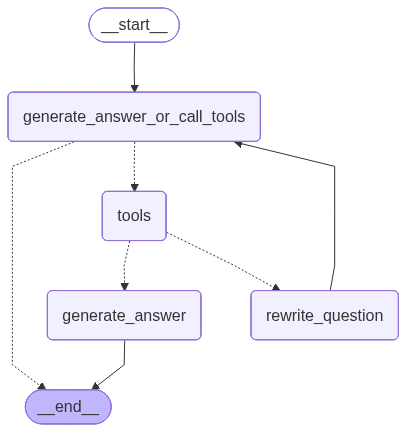

In [54]:
graph

In [ ]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Que fait Diag n'Grow ?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        message = update["messages"][-1]
        if (
            hasattr(message, "name")
            and message.name == "retrieve_in_vector_database"
            and hasattr(message, "content")
        ):
            print(message.content[:20])
        else:
            message.pretty_print()
        print("\n\n")

Update from node generate_answer_or_call_tools
================================== Ai Message ==================================
Tool Calls:
  retrieve_in_vector_database (iYw2wSQ9s)
 Call ID: iYw2wSQ9s
  Args:
    query: Que fait Diag n'Grow ? Quelle est son activité principale ?



Update from node tools
================================= Tool Message =================================
Name: retrieve_in_vector_database

Conclusion

Diag n'Grow dispose de tous les atouts pour devenir un acteur majeur de la valorisation des actifs immatériels en France. Notre équipe expérimentée, notre approche innovante et notre stratégie de croissance maîtrisée nous positionnent idéalement pour atteindre nos objectifs ambitieux à horizon 2027.

Contact : contact@diagngrow.fr

Business Plan Diag n'Grow 2025-2027

Résumé Exécutif

Diag n'Grow est une entreprise spécialisée dans l'audit et la valorisation des actifs immatériels (logiciels, brevets, marques). Notre mission est d'accompagner les entreprises 

In [ ]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Quel age à la fondatrice de Diag n'Grow dans les documents ?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        message = update["messages"][-1]
        if (
            hasattr(message, "name")
            and message.name == "retrieve_in_vector_database"
            and hasattr(message, "content")
        ):
            print(message.content[:20])
        else:
            message.pretty_print()
        print("\n\n")